# Indirect Object Identification

Basic reproduction of some of the findings from [Interpretability in the Wild](http://example.com). A lot of this is taken from Neel Nanda's notebook in the TransformerLens library, but I found rewriting the code to help improve my understanding of what's going on.

In [1]:
import torch
from transformer_lens import HookedTransformer
import plotly.io as pio
pio.renderers.default = "png"

device = torch.device("cpu")
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")

torch.set_grad_enabled(False)

# NBVAL_IGNORE_OUTPUT
model = HookedTransformer.from_pretrained(
    "gpt2-small",
    center_unembed=True,
    center_writing_weights=True,
    fold_ln=True,
    refactor_factored_attn_matrices=True,
)

/Users/richardlayte/Work/layterz/experiments/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loaded pretrained model gpt2-small into HookedTransformer


This sets up a model using [TransformerLens](https://github.com), which let's you inspect and manipulate the internal layers of language models. We also disable auto grad because we're only using the model for inference in these experiments.

Now we can test the model is working.

In [2]:
prompt = "John and Mary went to the shops. John gave the bag to"
output = model(prompt)
output.shape

torch.Size([1, 14, 50257])

The output structure is `(batch, token_positions, logits)` so to get the predicted token you can take the max value from the final token's logits.

In [3]:
pred = model.tokenizer.decode(output[:, -1, :].argmax(-1))
print(f'{prompt} ...{pred}')

John and Mary went to the shops. John gave the bag to ... Mary


You can call the model with `run_with_cache` that allows you to explore how this prediction was generated by looking at the internal layers of the model. We can then use the returned `ActivationCache` to explore predictions made from earlier layers.

In [4]:
output, cache = model.run_with_cache(prompt)

for layer in range(model.cfg.n_layers):
    resid_stream = cache['resid_post', layer]
    resid_stream = cache.apply_ln_to_stack(resid_stream, layer)
    logits = model.unembed(resid_stream)
    pred_token = logits[:, -1, :].argmax(-1)
    pred = model.tokenizer.decode(pred_token)
    print(f'Layer {layer}: {prompt} ...{pred} ({logits[:, -1, pred_token].item():.2f})')

Layer 0: John and Mary went to the shops. John gave the bag to ... avoid (157.73)
Layer 1: John and Mary went to the shops. John gave the bag to ... get (17.42)
Layer 2: John and Mary went to the shops. John gave the bag to ... help (17.81)
Layer 3: John and Mary went to the shops. John gave the bag to ... be (18.56)
Layer 4: John and Mary went to the shops. John gave the bag to ... cover (19.58)
Layer 5: John and Mary went to the shops. John gave the bag to ... go (19.34)
Layer 6: John and Mary went to the shops. John gave the bag to ... go (19.94)
Layer 7: John and Mary went to the shops. John gave the bag to ... someone (23.19)
Layer 8: John and Mary went to the shops. John gave the bag to ... Mrs (30.76)
Layer 9: John and Mary went to the shops. John gave the bag to ... Mary (55.80)
Layer 10: John and Mary went to the shops. John gave the bag to ... Mary (47.29)
Layer 11: John and Mary went to the shops. John gave the bag to ... Mary (36.26)


### Logit difference metric

Embedding spaces don't have a defined basis (e.g. like north/south, left/right, etc) so the paper defines one using the direction defined between the `S` (subject, e.g. "John") and `IO` (indirect object, e.g. "Mary"). Logit difference can then be calculated by how much the output of a component (e.g. an attention head) points in this direction.

This is a useful metric because it allows us to isolate how a component contributes to the task at hand (IOI) and ignores other work the components may be doing - e.g. deciding that it's an IOI task.

In [5]:
from itertools import permutations, product

names = (" Mary", " John", " Alice")
places = (" shops", " park", " beach")
things = (" bag", " ball", " book")

templates = [
    (
        "When{2} and{3} went to the{0}.{2} gave the{1} to",
        (place, thing),
        permutations(names, 2),
    )
    for place, thing in product(places, things)
]

prompts = [
    (prompt.format(place, thing, S, IO), (IO, S))
    for prompt, (place, thing), names in templates
    for S, IO in names
]

len(prompts), prompts[:5]

(54,
 [('When Mary and John went to the shops. Mary gave the bag to',
   (' John', ' Mary')),
  ('When Mary and Alice went to the shops. Mary gave the bag to',
   (' Alice', ' Mary')),
  ('When John and Mary went to the shops. John gave the bag to',
   (' Mary', ' John')),
  ('When John and Alice went to the shops. John gave the bag to',
   (' Alice', ' John')),
  ('When Alice and Mary went to the shops. Alice gave the bag to',
   (' Mary', ' Alice'))])

The above code creates a dataset of prompts that we can use to test the model's behaviour on the IOI task. Each prompt has two answers - the direction between these tokens in embedding space is used as the basis to determine the logit difference. Each prompt is also reversed to account for the model handling specific names or entities in unrelated ways.

To demonstrate this let's plot how much each layer contributes to the final logits using the logit difference metric. First, we need to calculate the directions between the possible completions we're interested in (e.g " John" or " Mary").

In [6]:
_, cache = model.run_with_cache([p[0] for p in prompts])

pred_tokens = torch.tensor(
    [
        [model.to_single_token(c) for c in completions] for _, completions in prompts
    ]
).to(device)

resid_directions = model.tokens_to_residual_directions(pred_tokens)
logit_diff_directions = resid_directions[:, 0] - resid_directions[:, 1]
logit_diff_directions.shape

torch.Size([54, 768])

This converts the possible completions to tokens, determines their direction in embedding space, and then calculates the difference between those directions. We can now determine how much the residual stream at each layer writes towards that direction.

In [7]:
resid_stream = cache['resid_post', -1]
resid_stream = cache.apply_ln_to_stack(resid_stream, -1)

resid_stream.shape

torch.Size([54, 15, 768])

In [8]:
from fancy_einsum import einsum

resid_stream = cache['resid_post', -1]
resid_stream = cache.apply_ln_to_stack(resid_stream, -1)

final_token_logit_diff = einsum(
    "... batch d_model, batch d_model -> ...",
    resid_stream[:, -1, :], logit_diff_directions,
) / len(prompts)

final_token_logit_diff.item()

3.258918523788452

Now let's plot this value over each layer to get a sense of how the model processes the full input.

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


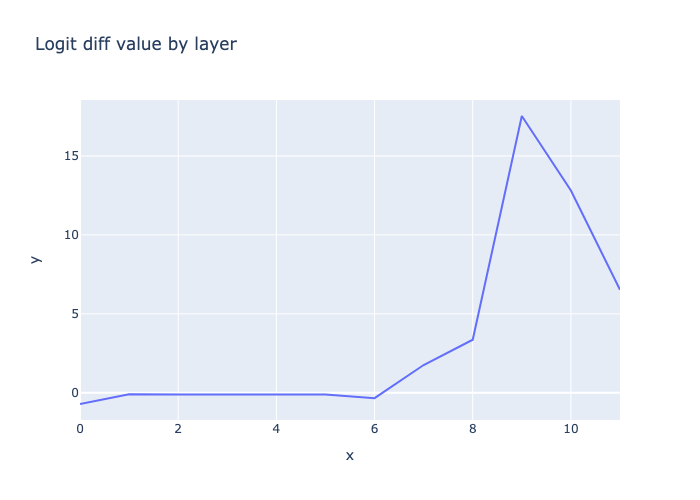

In [9]:
from plotly import express as px

y = []
for layer in range(model.cfg.n_layers):
    resid_stream = cache['resid_post', layer]
    resid_stream = cache.apply_ln_to_stack(resid_stream, layer)
    y += [
        einsum(
            "... batch d_model, batch d_model -> ...",
            resid_stream[:, -1, :], logit_diff_directions,
        ) / len(prompts)
    ]

y = [e.item() for e in y]
x = range(len(y))
px.line(x=x, y=y, title="Logit diff value by layer")

### Attention heads

We can do the same thing for attention heads by calculating how much the output of each head writes in the direction of the `S -> IO`.

Tried to stack head results when they weren't cached. Computing head results now


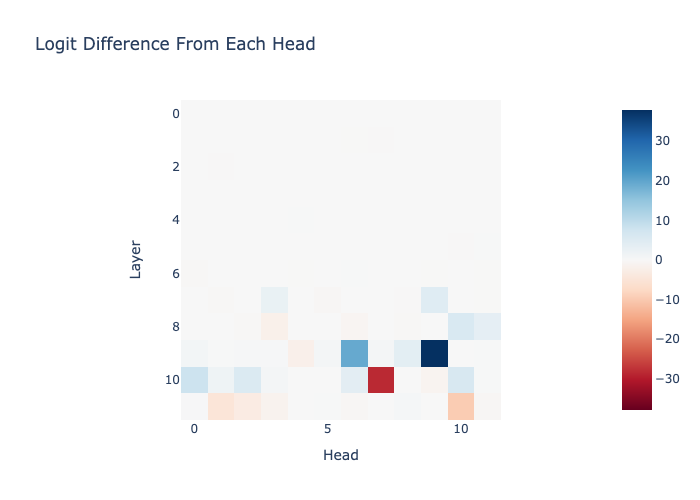

In [10]:
import einops

per_head_residual, labels = cache.stack_head_results(
    layer=-1, pos_slice=-1, return_labels=True
)

per_head_logit_diffs = einsum(
    "... batch d_model, batch d_model -> ...",
    per_head_residual, logit_diff_directions,
) / len(prompts)

per_head_logit_diffs = einops.rearrange(
    per_head_logit_diffs,
    "(layer head_index) -> layer head_index",
    layer=model.cfg.n_layers,
    head_index=model.cfg.n_heads,
)

px.imshow(
    per_head_logit_diffs.cpu(),
    labels={"x": "Head", "y": "Layer"},
    title="Logit Difference From Each Head",
    color_continuous_midpoint=0.0,
    color_continuous_scale="RdBu",
)

This shows us which heads are contributing most to the expected output - e.g. heads...

However, it doesn't tell us anything about *what* these heads are doing. To try and understand that we can visualize the attention patterns generated by each head using `circuitsvis`.

In [11]:
from IPython.display import HTML
from circuitsvis.attention import attention_heads

def visualize_attention_patterns(heads, cache, prompts):
    labels, patterns = [], []
    for head in heads:
        layer = head // model.cfg.n_heads
        head_index = head % model.cfg.n_heads
        labels.append(f"L{layer}H{head_index}")
        patterns.append(cache["attn", layer][0, head_index])

    patterns = torch.stack(patterns, dim=0)
    tokens = model.to_str_tokens(prompts[0][0])

    return attention_heads(
        attention=patterns, tokens=tokens, attention_head_names=labels
    ).show_code()


Now we can visualize the top contributing heads based on logit difference

In [12]:
heads = torch.topk(per_head_logit_diffs.flatten(), k=3).indices
HTML(visualize_attention_patterns(heads, cache, prompts))

I think it's often useful to view all the heads see if there are any attention patterns that stand out and any motifs that reoccur across patterns.

In [13]:
HTML(visualize_attention_patterns(range(12), cache, prompts))

## Identifying the IOI circuit

![ioi](./ioi-circuit.png)

The techniques above help us understand which heads and layers are important for producing the output, but don't help to explain how they connect to each other. For the outer layers this doesn't matter because we can see how they connect to the inputs/outputs, but to understand the internal layers we need to trace how computations flow between heads.

The paper uses activation or path patching to disciver possible circuits by testing how replacing activations within the model's internal layers affects the output. By systematically replacing head activations with corrupted activations (i.e. activations from other inputs or random noise) we can gain some insight into how heads are connected. These connected subgraphs of heads form "circuits" that implement some sort of behaviour.

Before attempting to locate any circuits let's look at how to patch activations using TransformerLens - we start by creating corrupted prompts where the completions have been reversed so the subject instead of the indirect object is the expected output.

In [14]:
templates = [
    (
        "When{2} and{3} went to the{0}.{3} gave the{1} to",
        (place, thing),
        permutations(names, 2),
    )
    for place, thing in product(places, things)
]

corrupted_prompts = [
    (prompt.format(place, thing, S, IO), (IO, S))
    for prompt, (place, thing), names in templates
    for S, IO in names
]

corrupted_prompts[:5]

[('When Mary and John went to the shops. John gave the bag to',
  (' John', ' Mary')),
 ('When Mary and Alice went to the shops. Alice gave the bag to',
  (' Alice', ' Mary')),
 ('When John and Mary went to the shops. Mary gave the bag to',
  (' Mary', ' John')),
 ('When John and Alice went to the shops. Alice gave the bag to',
  (' Alice', ' John')),
 ('When Alice and Mary went to the shops. Mary gave the bag to',
  (' Mary', ' Alice'))]

The corrupted prompts are the same as the clean prompts apart from the reversal of the subject and indirect-object terms.

In [15]:
corrupted_logits, corrupted_cache = model.run_with_cache(
    [prompt for prompt, _ in corrupted_prompts], return_type="logits"
)

corrupted_resid_stream = corrupted_cache['resid_post', -1]
corrupted_resid_stream = corrupted_cache.apply_ln_to_stack(corrupted_resid_stream, -1)
corrupted_final_token_logit_diff = einsum(
    "... batch d_model, batch d_model -> ...",
    corrupted_resid_stream[:, -1, :], logit_diff_directions,
) / len(prompts)

corrupted_final_token_logit_diff.item()

-3.436338424682617

As we expect to see, the logit difference is now a negative value close to the difference calculated for the clean activations. Now we can see if we can recover the performance by patching the relevant components with the clean activations.

In [16]:
from functools import partial
from transformer_lens import utils

def patch_residual_component(corrupted_residual_component, hook, pos, clean_cache):
    corrupted_residual_component[:, pos, :] = clean_cache[hook.name][:, pos, :]
    return corrupted_residual_component

hook_fn = partial(patch_residual_component, pos=-1, clean_cache=cache)
model.remove_all_hook_fns()
model.add_hook(utils.get_act_name('resid_post', 11), hook_fn)

_, patched_cache = model.run_with_cache([p for p, _ in corrupted_prompts])
patched_resid_stream = patched_cache['resid_post', -1]
patched_resid_stream = patched_cache.apply_ln_to_stack(patched_resid_stream, -1)

patched_final_token_logit_diff = einsum(
    "... batch d_model, batch d_model -> ...",
    patched_resid_stream[:, -1, :], logit_diff_directions,
) / len(corrupted_prompts)

patched_final_token_logit_diff.item()

3.258918523788452

Patching the final residual stream layer recovers the full performance - patching earlier layers has little effect until layer 9 which is what we'd expect to see based on the analysis above.

We can also patch indivdual heads.

In [17]:
def patch_attention_head(corrupted_head, hook, head_index, clean_cache):
    corrupted_head[:, :, head_index, :] = clean_cache[hook.name][:, :, head_index, :]
    return corrupted_head

hook_fn = partial(patch_attention_head, head_index=9, clean_cache=cache)
model.remove_all_hook_fns()
model.add_hook(utils.get_act_name('z', 9, 'attn'), partial(patch_attention_head, head_index=9, clean_cache=cache))
model.add_hook(utils.get_act_name('z', 9, 'attn'), partial(patch_attention_head, head_index=6, clean_cache=cache))
model.add_hook(utils.get_act_name('z', 10, 'attn'), partial(patch_attention_head, head_index=0, clean_cache=cache))

_, patched_cache = model.run_with_cache([p for p, _ in corrupted_prompts])
patched_resid_stream = patched_cache['resid_post', -1]
patched_resid_stream = patched_cache.apply_ln_to_stack(patched_resid_stream, -1)

patched_final_token_logit_diff = einsum(
    "... batch d_model, batch d_model -> ...",
    patched_resid_stream[:, -1, :], logit_diff_directions,
) / len(corrupted_prompts)

patched_final_token_logit_diff.item()

-1.6868280172348022

Patching the top 3 heads based on logit difference improves from -3.24 to -1.69.

TransformerLens has a `patching` module, which allows us to run this process in a more systematic way.

In [18]:
final_token_logit_diff.item(), corrupted_final_token_logit_diff.item()

(3.258918523788452, -3.436338424682617)

In [19]:
import transformer_lens.patching as patching

CLEAN_BASELINE = final_token_logit_diff.item()
CORRUPTED_BASELINE = corrupted_final_token_logit_diff.item()

def get_logit_diff(logits, answer_token_indices):
    if len(logits.shape)==3:
        logits = logits[:, -1, :]
    correct_logits = logits.gather(1, answer_token_indices[:, 0].unsqueeze(1))
    incorrect_logits = logits.gather(1, answer_token_indices[:, 1].unsqueeze(1))
    return (correct_logits - incorrect_logits).mean()

def ioi_metric(logits, answer_token_indices=None):
    return (get_logit_diff(logits, answer_token_indices) - CORRUPTED_BASELINE) / (CLEAN_BASELINE  - CORRUPTED_BASELINE)

clean_tokens = model.to_tokens([p for p, _ in prompts])
corrupted_tokens = model.to_tokens([p for p, _ in corrupted_prompts])
#results = patching.get_act_patch_resid_pre(model, corrupted_tokens, cache, partial(ioi_metric, answer_token_indices=pred_tokens))

Now let's use patching to try and discover the same circuits outlined in the paper.

### Refactoring into functions

To avoid repeating a lot of the same code I've rewritten some of the above as utility functions. You can safely skip this and just focus on the outputs, which are hopefully clear in context.

In [20]:
from itertools import permutations, product
import einops
from fancy_einsum import einsum
from plotly import express as px
from IPython.display import HTML
from circuitsvis.attention import attention_heads

def calculate_logit_diff(cache):
    pred_tokens = torch.tensor([
        [model.to_single_token(c) for c in completions] 
        for _, completions in cache.prompts
    ]).to(device)

    resid_directions = cache.model.tokens_to_residual_directions(pred_tokens)
    return resid_directions[:, 0] - resid_directions[:, 1]

def calculate_head_contribution(cache):
    per_head_residual, labels = cache.stack_head_results(
        layer=-1, pos_slice=-1, return_labels=True
    )

    logit_diff_directions = calculate_logit_diff(cache)
    per_head_logit_diffs = einsum(
        "... batch d_model, batch d_model -> ...",
        per_head_residual, logit_diff_directions,
    ) / len(cache.prompts)

    return einops.rearrange(
        per_head_logit_diffs,
        "(layer head_index) -> layer head_index",
        layer=cache.model.cfg.n_layers,
        head_index=cache.model.cfg.n_heads,
    )

def plot_head_contribution(cache, layer=-1, pos_slice=-1):
    per_head_residual, labels = cache.stack_head_results(
        layer=-1, pos_slice=-1, return_labels=True
    )

    logit_diff_directions = calculate_logit_diff(cache)
    per_head_logit_diffs = einsum(
        "... batch d_model, batch d_model -> ...",
        per_head_residual, logit_diff_directions,
    ) / len(cache.prompts)

    per_head_logit_diffs = einops.rearrange(
        per_head_logit_diffs,
        "(layer head_index) -> layer head_index",
        layer=cache.model.cfg.n_layers,
        head_index=cache.model.cfg.n_heads,
    )

    return px.imshow(
        per_head_logit_diffs.cpu(),
        labels={"x": "Head", "y": "Layer"},
        title="Logit Difference From Each Head",
        color_continuous_midpoint=0.0,
        color_continuous_scale="RdBu",
    )

def visualize_attention_patterns(heads, cache, prompts):
    labels, patterns = [], []
    for head in heads:
        layer = head // model.cfg.n_heads
        head_index = head % model.cfg.n_heads
        labels.append(f"L{layer}H{head_index}")
        patterns.append(cache["attn", layer][0, head_index])

    patterns = torch.stack(patterns, dim=0)
    tokens = model.to_str_tokens(prompts[0][0])

    return attention_heads(
        attention=patterns, tokens=tokens, attention_head_names=labels
    ).show_code()

def generate_prompts(t):
    names = (" Mary", " John", " Alice")
    places = (" shops", " park", " beach")
    things = (" bag", " ball", " book")

    templates = [
        (
            t, (place, thing), permutations(names, 2),
        )
        for place, thing in product(places, things)
    ]

    return [
        (prompt.format(place, thing, S, IO), (IO, S))
        for prompt, (place, thing), names in templates
        for S, IO in names
    ]


In [21]:
prompts = generate_prompts("When{2} and{3} went to the{0}.{2} gave the{1} to")
prompts[:5]

[('When Mary and John went to the shops. Mary gave the bag to',
  (' John', ' Mary')),
 ('When Mary and Alice went to the shops. Mary gave the bag to',
  (' Alice', ' Mary')),
 ('When John and Mary went to the shops. John gave the bag to',
  (' Mary', ' John')),
 ('When John and Alice went to the shops. John gave the bag to',
  (' Alice', ' John')),
 ('When Alice and Mary went to the shops. Alice gave the bag to',
  (' Mary', ' Alice'))]

Tried to stack head results when they weren't cached. Computing head results now


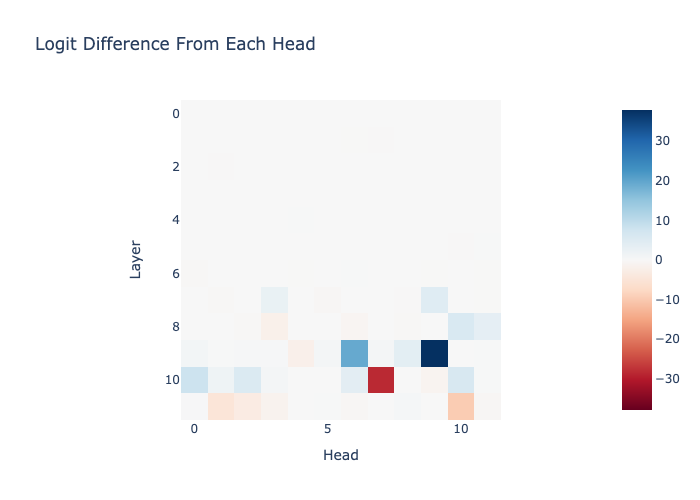

In [22]:
model.remove_all_hook_fns()
_, cache = model.run_with_cache([p[0] for p in prompts])
cache.prompts = prompts
plot_head_contribution(cache)


In [23]:
HTML(visualize_attention_patterns(range(144), cache, prompts))

### Name mover heads

The paper starts by looking for the heads that most directly contribute to the final logits output. They find heads 9.9, 9.6, and 10.0 to have the highest correlation and call them "name mover heads" because they appear to attend to previous names and copy the value directly to residual stream.

We can see that to be the case by visualizing the contribution of each head.

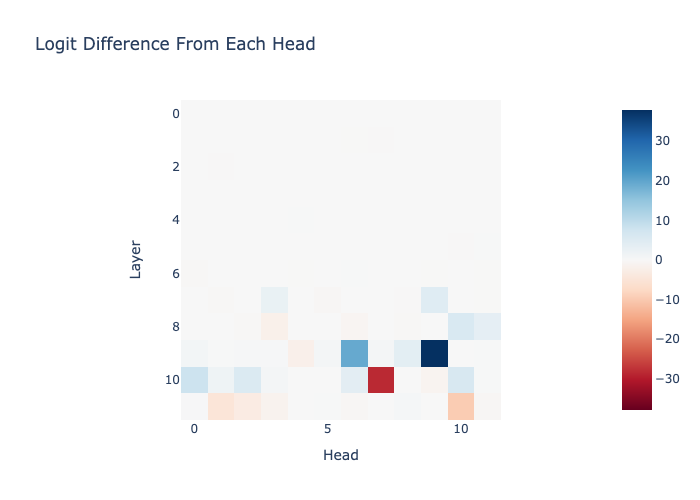

In [24]:
plot_head_contribution(cache)

We can plot the top head attention pattern by contribution to see what they are actually doing.

In [25]:
per_head_logit_diffs = calculate_head_contribution(cache)
heads = torch.topk(per_head_logit_diffs.flatten(), k=12).indices
HTML(visualize_attention_patterns(heads, cache, prompts))

There's a lot of symmetry here between the positive and negaative contributions. In this case we have name-movers and negative name-movers, but other similarities are clear - e.g. 7.9 -> 11.3, 8.11 -> 7.5.

In [26]:
per_head_logit_diffs = calculate_head_contribution(cache)
heads = torch.topk(-per_head_logit_diffs.flatten(), k=12).indices
HTML(visualize_attention_patterns(heads, cache, prompts))

Iterestingly, one of the backup name mover heads (11.2) is ranked 4th in the negative head contributions.

To test the assumption that the name mover heads (9.9, 9.6, 10.0) attend to a name and copy the value we can plot how much each head 

### S-Inhibition heads

The above explains how the output value is written from the name mover heads - they attend to the IO token as the name and copy that value into the residual stream. However, that doesn't explain why the heads attend to the IO token.

The paper suggests that this is governed by S-Inhibition heads - i.e. heads that write in oppostite direction to the subject tokens position. This could be done in the either the Q, K, of V components of the attention head, but the paper focuses on Q based on V being responsible for copying the token value and K being early in the context and therefore unlikely to contain much useful data.

In [27]:
s_inhibition_heads = [
    7 * 12 + 3,
    7 * 12 + 9,
    8 * 12 + 10,
    8 * 12 + 6,
]

HTML(visualize_attention_patterns(s_inhibition_heads, cache, prompts))

### What influences the S-Inhibition heads?

If the S-Inhibition heads write in the opposite direction to the subject in their Q component, how do they determine which token is the subject? The paper identifies three classes of heads that collaborate to identify subject and indirect-object - previous token, duplicate token, and induction heads.

In [28]:
duplicate_token_heads = [
    0 * 12 + 1,
    0 * 12 + 10,
    3 * 12 + 0,
]

HTML(visualize_attention_patterns(duplicate_token_heads, cache, prompts))

In [29]:
previous_token_heads = [
    2 * 12 + 2,
    4 * 12 + 11,
]

HTML(visualize_attention_patterns(previous_token_heads, cache, prompts))

In [30]:
induction_heads = [
    5 * 12 + 5,
    6 * 12 + 9,
    5 * 12 + 8,
    5 * 12 + 9,
]

HTML(visualize_attention_patterns(induction_heads, cache, prompts))

### Duplicate token heads

### Previous token heads

### Induction heads